# 2. Regresión

En este notebook aprendarás a resolver un problema sencillo de regresión usando Pytorch. De esta forma nos familiarizaremos con este framework: cómo se define un modelo, cómo se entrena y cómo se predice. Además, introduciremos el concepto de red neuronal, el cual nos será útil para tareas más complejas.

### ¿Cómo lo haremos?
El proceso para diseñar e implementar una red neuronal para regresión en Pytorch lo podemos dividir en los siguientes pasos:
1. Crear o cargar el conjunto de datos, y preprocesarlos en el caso de que sea necesario. A veces en este paso puede ser interesante hacer algunas consultas sobre el conjunto para saber con qué tipo de datos estamos tratando. 
2. Preparar el conjunto de datos para la tarea de aprendizaje que llevaremos a cabo: dividir en subconjuntos de train, test (y validación si se requiere), establecer el número de batches, etc.
3. Diseño e implementación del modelo que consideremos que podemos utilizar para resolver nuestro problema. 
4. Entrenar el modelo que hemos implementado.
5. Evaluar el modelo que hemos implementado y posteriormente entrenado.
6. Si procede, almacenar el modelo entrenado para poder usarlo en tareas posteriores sin tener que volver a realizar el paso (4). 

A lo largo de este notebook veremos cómo a través de estos pasos podremos resolver un problema de regresión partiendo desde cero.

## Antes de comenzar

Lo primero es cargar las librerías que necesitamos para poder ejecutar de forma correcta el notebook. 
Instalamos la librería **pytorch** (aparece en el notebook como *torch*) para poder utilizar los métodos relativos a datos y regresión. Además instalamos la librería **matplotlib** (aparece en el notebook como *plt*) para todo lo relativo a visualizaciones de datos.

In [1]:
import torch
import matplotlib.pyplot as plt

## Aprendiendo a optimizar un modelo lineal

Definimos un problema de regresión sencillo. Observamos 10 puntos de la función definida a continuación:

$$f(x)=\sin(3x)+x$$


Para generar los puntos vamos a hacer uso de los recursos relativos a datos aleatorios de Pytorch. Lo primero es seleccionar una semilla que nos permita que el resultado sea reproducible en futuras ejecuciones del notebook. A continuación definimos 10 puntos aleatorios (a los que nos referiremos como $x_{i}$) y la función, y obtenemos el valor $y_{i}$ asociado a cada valor $x_{i}$ generado previamente.


In [2]:
torch.random.manual_seed(100) # Seleccionamos una semilla para que sea reproducible
x = torch.rand(10).unsqueeze(-1) # Elementos aleatorios (uniforme) en [0, 1)
y = torch.sin(3*x) + x

Podemos visualizar estos puntos como sigue a continuación:

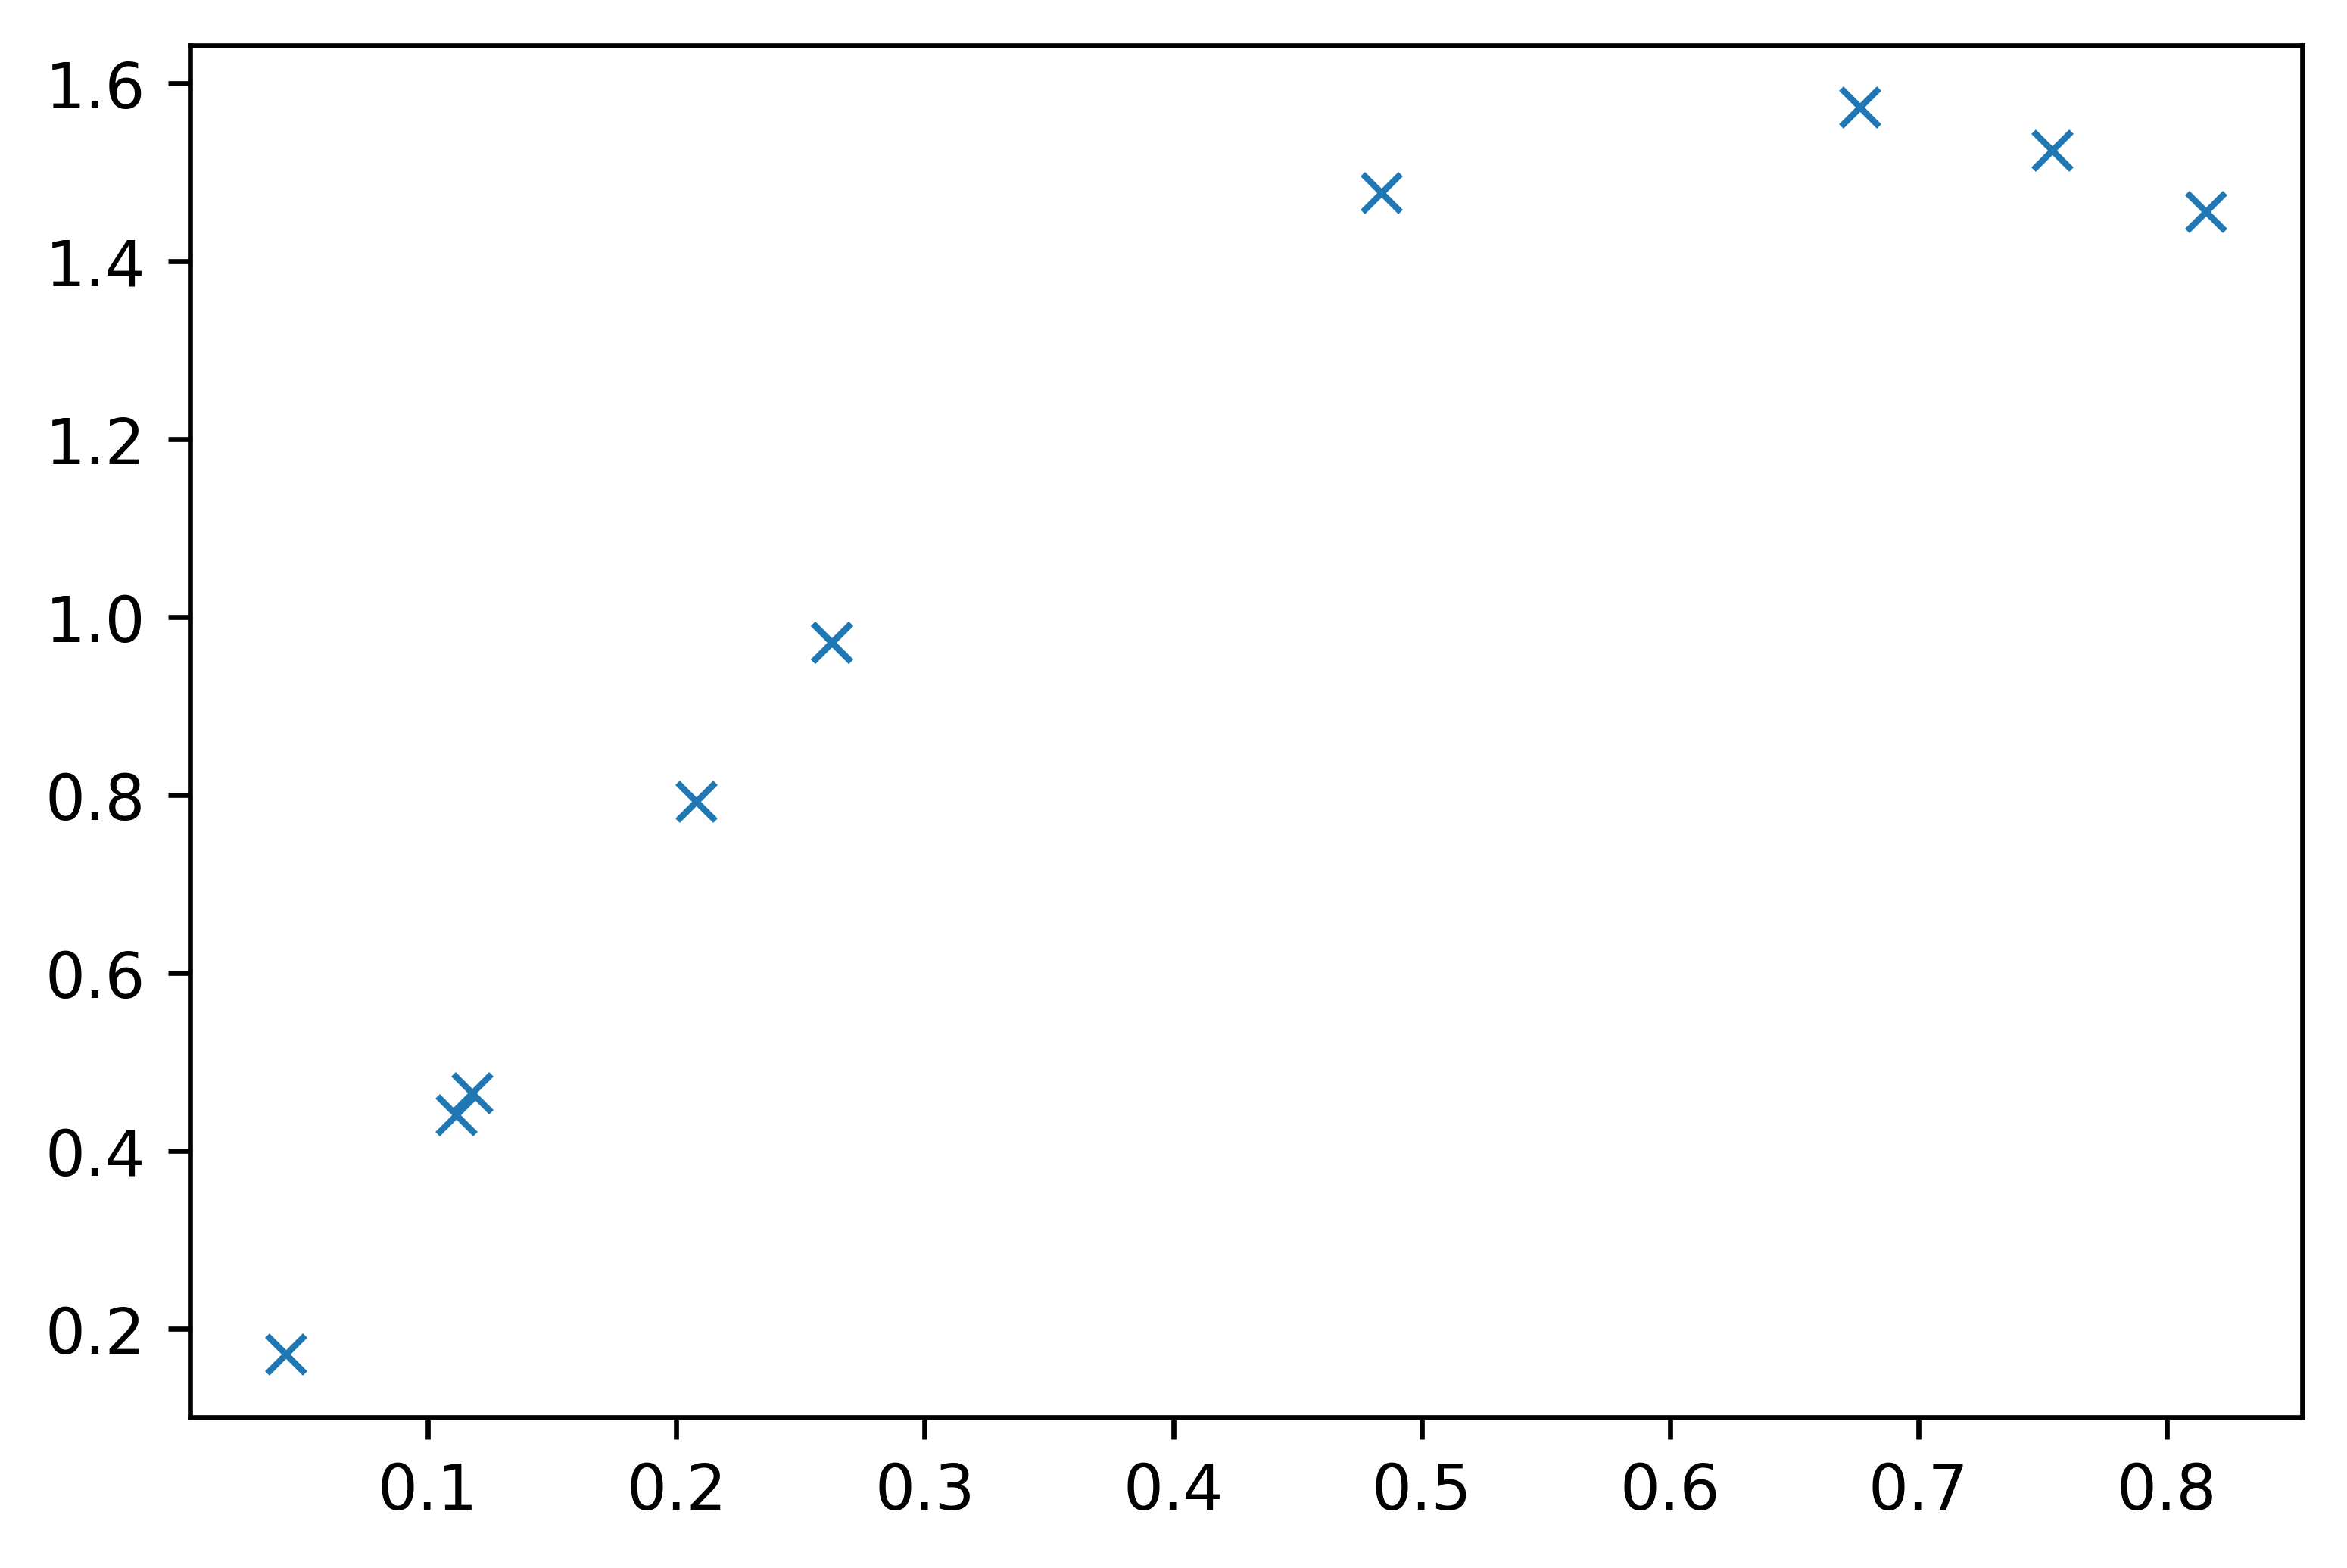

In [3]:
plt.figure(dpi=600)
plt.plot(x, y, 'x')
plt.show()

### Modelo lineal

Definimos un modelo lineal, este modelo será de la forma: 

$$model(x) = w * x + b$$

Le daremos un input $x$, el cual será multiplicado por un peso $w$ y sumado por un 'sesgo' $b$. Nuestro objetivo consiste en aprender los parámetros $w$ y $b$ óptimos que se ajusten a nuestros datos, es decir, tal que $f(x)\sim model(x)$.

**¿Cómo sabemos que unos parámetros se ajustan bien a nuestros datos?**

¡Mediante una función de pérdida! Esta función nos dirá como de buenos son nuestros parámetros para los datos observados. En regresión, es muy popular el **error cuadrático medio (MSE)**, el cual se define como el promedio de las diferencias al cuadrado de los valores observados $y$ y los valores predichos $y'=model(x)$:

$$loss_{MSE}(y, y') = \frac{1}{N}\sum_{i=1}^{N}(y_i-y'_i)²$$

In [ ]:
# Modelo lineal
def model(x, w, b):
    return w * x + b

# Función de pérdida
def loss_fn(y_real, y_pred):
    squared_diffs = (y_real - y_pred)**2
    return squared_diffs.mean()

Podemos inicializar los parámetros de manera aleatoria, predecir nuestros datos con el modelo y ver qué pérdida tiene. En otras palabras, de esta forma podemos ver cómo de bien se ajusta un modelo con parámetros aleatorios a nuestros datos. ¡No hemos realizado ningún tipo de tarea de aprendizaje aún! 

In [ ]:
w = torch.rand(1)
b = torch.rand(1)

y_pred = model(x, w, b)
y_pred

A continuación podemos consultar el error de nuestro modelo, tal y como hemos hecho antes.

In [ ]:
loss = loss_fn(y, y_pred)
loss

Lo que queremos es obtener los parámetros w y b óptimos para nuestro modelo. Quizás la mejor manera sea muestrear parámetros de manera aleatoria y ver cuáles tienen menor pérdida... PERO NO. Podemos hacer un proceso de optimización que vaya hacia los parámetros óptimos. Esto se consigue minimizando la pérdida respecto a los parámetros (esto se llama *backpropagation*). Obtenemos las derivadas (gradiente) respecto a los parámetros, y actualizamos los parámetros dando un paso en el gradiente (esto se llama gradiente descendente).

Para calcular el gradiente tenemos que usar la tan AMADA regla de la cadena, teniendo en cuenta que $ y = model(x) = w*x + b$:

$$ \frac{\partial loss (x, w, b)}{\partial w} = \frac{\partial loss (x, w, b)}{\partial model}\times\frac{\partial model (x, w, b)}{\partial w} = \frac{2}{N}(y-model(x)) * x$$

$$ \frac{\partial loss (x, w, b)}{\partial b} = \frac{\partial loss (x, w, b)}{\partial model}\times\frac{\partial model (x, w, b)}{\partial b} = \frac{2}{N}(y-model(x)) * 1$$

Dado un valor en un instante $t-1$ de los parámetros, el siguiente valor $t$ óptimo será:

$$w_{t} = w_{t-1} - l * \frac{\partial loss (x, w_{t-1}, b_{t-1})}{\partial w}$$
$$b_{t} = b_{t-1} - l * \frac{\partial loss (x, w_{t-1}, b_{t-1})}{\partial b}$$

Con este método iterativo vamos minimizando la pérdida en los parámetros avanzando en la dirección del gradiente que lo minimiza. En estas ecuaciones $l$ es lo que conocemos como tasa de aprendizaje (o *learning rate*) que controla como de rápido avanzamos en la dirección del gradiente, tiene que ser el adecuado, ni muy grande ni muy pequeño y para cada problema cambia, eso sí que es un problemón.

In [ ]:
def dloss_fn(y_real, y_pred):
    dsq_diffs = 2 * (y_pred - y_real) / y.size(0)
    return dsq_diffs

def dmodel_dw(x, w, b):
    return x

def dmodel_db(x, w, b):
    return 1.0

def grad_fn(y, y_pred, x, w, b):
    dloss_dy = dloss_fn(y, y_pred)
    dloss_dw = dloss_dy * dmodel_dw(x, w, b)
    dloss_db = dloss_dy * dmodel_db(x, w, b)
    # print(dloss_dw, dloss_db)
    return torch.stack([dloss_dw.sum(), dloss_db.sum()])  

Hay que tener en cuenta la normalización de los datos. Si los datos no estuvieran normalizados el gradiente afectaría distinto a cada parámetro provocando inestabilidades. Para solventar esto, es deseable que los datos de entrada para nuestro modelo esté entre -1 y 1.

Definimos un bucle de entrenamiento donde hacemos nuestra tan ansiada backpropagación:

In [ ]:
def training_loop(n_epochs, learning_rate, params, x, y):
    for epoch in range(1, n_epochs + 1):
        w, b = params

        y_pred = model(x, w, b)  # <1>
        loss = loss_fn(y, y_pred)
        grad = grad_fn(y, y_pred, x, w, b)  # <2>
        
        # print(grad)

        params = params - learning_rate * grad
        
        if epoch % 10 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss))) # <3>
            
    return params

Vemos que va bajando la pérdida a través de las épocas:

In [ ]:
params = training_loop(
    n_epochs = 100, 
    learning_rate = 1e-2, 
    params = torch.tensor([1.0, 0.0]), 
    x = x, 
    y = y)

Podemos calcular el error cuadrático y pintar la recta que mejor se ha ajustado a nuestros datos. Esta recta es una maravilla y consigue modelar nuestra función $f(x)$, ¿verdad? Pues no. Nuestra función no es lineal por lo que difícilmente podremos tener algo satisfactorio con algo lineal.

In [ ]:
x_grid = torch.linspace(0, 1, 100)
y_pred_grid = model(x_grid, *params)
y_pred = model(x, *params)  # <1>
loss = loss_fn(y, y_pred)
plt.figure(dpi = 600)
plt.plot(x, y, 'x')
plt.plot(x_grid, y_pred_grid)
plt.title("Error cuadrático: " + str(loss.numpy()))
plt.show()

## Autograd: Pytorch nos calcula las derivadas por nosotros!

El verdadero potencial de Pytorch está en el autograd. Pytorch es capaz de calcular el gradiente (las derivadas) de forma automática. De esta forma, el aprendizaje de modelos (y como veremos posteriormente de redes neuronales) es muy directo y automático. Sin embargo, siempre es importante entender qué hacemos y por qué lo hacemos.

En primer lugar, para que un parámetro sea entrenable tendremos que especificar que queremos su gradiente, con la opción 'requires_grad' puesta a true.

In [ ]:
params = torch.tensor([1.0, 0.0], requires_grad = True)
params.grad is None

Con el atributo .backward() podemos calcular el gradiente de la pérdida respecto de los parámetros, podemos comprobar que da exactamente lo mismo que hacerlo a mano. En un modelo así de simple OK. En un modelo con millones de parámetros no tan OK.

In [ ]:
loss = loss_fn(y, model(x, *params))
loss.backward()

params.grad

In [ ]:
dw = 2 * torch.mean(x * (model(x, *params) - y)) # w derivative
db = 2 * torch.mean(model(x, *params) - y) # b derivative

print(dw, db)

Además Pytorch tiene distintos optimizadores, que dado el gradiente nos actualiza directamente los parámetros. El que hemos visto anteriormente sería similar al SGD (Gradiente descendente estocástico).

In [ ]:
import os
import torch.optim as optim

In [ ]:
dir(optim)

Para el optimizador tenemos que especificar el learning rate y qué parámetros queremos que nos optimice.

In [ ]:
learning_rate = 1e-5
optimizer = optim.SGD([params], lr=learning_rate)

Para hacer aquí la optimización de los parámetros tenemos que hacerlo del siguiente modo:
* 1. Calculamos la pérdida respecto del modelo actual con la función de pérdida
* 2. Ponemos los gradientes a cero del optimizador (para que no acumule gradientes anteriores) con .zero_grad()
* 3. Calculamos el nuevo gradiente con .backward()
* 4. Actualizamos los parámetros dando un paso en el gradiente con .step()

Podemos verlo en el siguiente bloque:

In [ ]:
loss = loss_fn(y, model(x, *params))
optimizer.zero_grad()
loss.backward()
optimizer.step()

params

In [ ]:
def training_loop(n_epochs, optimizer, params, x, y):
    for epoch in range(1, n_epochs + 1):
        y_pred = model(x, *params) 
        loss = loss_fn(y, y_pred)
        
        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()

        if epoch <= 3 or epoch % 500 == 0:
            print(f"Epoch {epoch}, loss {loss.item():.4f}")
            
    return params

In [ ]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    params = params,
    x = x, # <1> 
    y = y)

In [ ]:
x_grid = torch.linspace(0, 1, 100)
with torch.no_grad(): 
    y_pred_grid = model(x_grid, *params)
    y_pred = model(x, *params)  # <1>
loss = loss_fn(y, y_pred)
plt.figure(dpi = 600)
plt.plot(x, y, 'x')
plt.plot(x_grid, y_pred_grid.detach()) # Tenemos que extraer la variable del grafo de Pytorch
plt.title("Error cuadrático: " + str(loss.detach().numpy()))
plt.show()

> **Ejercicio 1:** Reproduce el ejemplo anterior usando un modelo cuadrático: $$f(x) = w_1 x² + w_0 x + b$$
¿Mejora los resultados?

## Mi primera red neuronal

Aquí a lo que hemos venido es a ver buenas redes neuronales. Para ello vamos a aprender el concepto básico más genuino de red neuronal con este ejemplo tan sencillo.

Lo primero es ver ejemplos de funciones de activación, estas funciones son no lineales. 

In [ ]:
import torch.nn as nn

In [ ]:
input_t = torch.arange(-3, 3.1, 0.1)

activation_list = [
    nn.Tanh(),
    nn.Hardtanh(),
    nn.Sigmoid(),
    
    nn.Softplus(),
    nn.ReLU(),
    nn.LeakyReLU(negative_slope=0.1),

    
    #nn.Tanhshrink(),
    #nn.Softshrink(),
    #nn.Hardshrink(),
]

fig = plt.figure(figsize=(14, 28), dpi=600)

for i, activation_func in enumerate(activation_list):
    subplot = fig.add_subplot(len(activation_list), 3, i+1)
    subplot.set_title(type(activation_func).__name__)
    
    output_t = activation_func(input_t)
    
    plt.grid()
    plt.plot(input_t.numpy(), input_t.numpy(),'k', linewidth=1)
    plt.plot([-3,3], [0,0], 'k', linewidth=1)
    plt.plot([0,0], [-3,3], 'k', linewidth=1)
    plt.plot(input_t.numpy(), output_t.numpy(), 'r', linewidth=3)

plt.show()

Una red neuronal es una composición de funciones.

In [ ]:
from ipywidgets import interact

@interact(w=(-3,3, 0.1), b=(-2,2, 0.5), act=activation_list)
def composition(w, b, act):
    linear = w * input_t + b
    activation = act(linear)

    fig = plt.figure(dpi=600)


    plt.grid()
    plt.ylim(-3, 3)
    plt.xlim(-3, 3)
    plt.plot(input_t.numpy(), input_t.numpy(),'k', linewidth=0.5)
    plt.plot([-3,3], [0,0], 'k', linewidth=0.5)
    plt.plot([0,0], [-3,3], 'k', linewidth=0.5)
    plt.plot(input_t.numpy(), linear.numpy(), 'g', linewidth=1, label='lineal')
    plt.plot(input_t.numpy(), act(input_t).numpy(), 'b', linewidth=1, label = 'activation')
    plt.plot(input_t.numpy(), activation.numpy(), 'r', linewidth=3, label = 'result')
    plt.title(f"{type(act).__name__}({w:.2f}x+{b})")
    plt.legend()

    plt.show()

Pytorch es modular y podemos definir la red neuronal como una clase.

In [ ]:

class First_NN(nn.Module):
    def __init__(self, activation, hidden_units):
        super().__init__() 
        
        self.hidden_linear = nn.Linear(1, hidden_units) # es el número de neuronas intermedias
        self.activation = activation
        self.output_linear = nn.Linear(hidden_units, 1)
        
    def forward(self, input):
        y = self.hidden_linear(input)
        y = self.activation(y)
        output = self.output_linear(y)
        
        return output
    
first_nn = First_NN(activation = nn.Tanh(), hidden_units = 20)
first_nn

In [ ]:
for name, param in first_nn.named_parameters():
    if param.requires_grad:
        print(name, param.data)

In [ ]:
[param.shape for param in first_nn.parameters()]

In [ ]:
for name, param in first_nn.named_parameters():
    print(name, param.shape)

Entrenamos la red neuronal con bucle homólogo al del modelo lineal:

In [ ]:
def training_loop(n_epochs, optimizer, model, x, y):
    for epoch in range(1, n_epochs + 1):
        y_pred = model(x) # <1>
        loss = loss_fn(y, y_pred)
        
        optimizer.zero_grad()
        loss.backward() # <2>
        optimizer.step()

        if epoch <= 3 or epoch % 500 == 0:
            print(f"Epoch {epoch}, loss {loss.item():.4f}")
            
    return model, loss

In [ ]:
first_nn = First_NN(activation = nn.ReLU(), hidden_units = 20)
learning_rate = 1e-1
optimizer = optim.SGD(first_nn.parameters(), lr=learning_rate)

first_nn_fit, loss = training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = first_nn,
    x = x, # <1> 
    y = y)

In [ ]:
x_grid = torch.linspace(0, 1, 100).unsqueeze(-1)
with torch.no_grad():
    y_pred_grid = first_nn(x_grid)
    y_pred = first_nn(x)  # <1>
loss = loss_fn(y, y_pred)
plt.figure(dpi = 600)
plt.plot(x, y, 'x')
plt.plot(x_grid, y_pred_grid.detach()) # Tenemos que extraer la variable del grafo de Pytorch
plt.title("Error cuadrático medio: " + str(loss.detach().numpy()))
plt.show()

Podemos jugar de forma interactiva con las opciones de la red neuronal para entender que significa cada parámetro.

In [ ]:
from ipywidgets import interact_manual
@interact_manual(hidden_units=(0,100), activation=activation_list, continous_update = False)
def train_nn(hidden_units, activation):
    print("Activaton = ", type(activation).__name__)
    print("Hidden Units = ", hidden_units)
    
    second_nn = First_NN(activation = activation, hidden_units = hidden_units)
    
    learning_rate = 1e-1
    optimizer = optim.SGD(second_nn.parameters(), lr=learning_rate)
    
    second_nn_fit, loss = training_loop(
        n_epochs = 10000, 
        optimizer = optimizer,
        model = second_nn,
        x = x,
        y = y)
    
    print("Final loss: ", loss)
    
    x_grid = torch.linspace(0, 1, 100).unsqueeze(-1)
    
    with torch.no_grad():
        y_pred_nn = second_nn_fit(x_grid)
        y_pred = second_nn_fit(x)
    loss = loss_fn(y, y_pred)
    plt.figure(dpi = 600)
    plt.plot(x, y, 'x')
    plt.plot(x_grid, y_pred_nn.detach()) # Tenemos que extraer la variable del grafo de Pytorch
    plt.title("Error cuadrático medio: " + str(loss.detach().numpy()))
    plt.show()
    

> **Ejercicio 2:** ¿Cómo afecta variar el tan importante learning rate en este ejemplo? ¿Y la profundidad de la red? Prueba distintas arquitecturas con distintas capas de activación.